# Exploratory Data Analysis (EDA)
This notebook provides an initial exploration of the malaria blood smear image dataset.  
We aim to understand the data structure, visualize sample images, check class balance, and identify potential issues before building models.

In [2]:
# Import necessary libraries
import os
import json
import yaml
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully!")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

Libraries imported successfully!
OpenCV version: 4.11.0
NumPy version: 2.3.1
Pandas version: 2.3.0
Matplotlib version: 3.10.3
Seaborn version: 0.13.2


## 1. Dataset Overview

We have two main datasets for this project:

1. **Cropped Dataset (NIH Malaria Dataset)**: 27,558 pre-cropped cell images
   - `data/raw/cropped/Parasitized/`: Malaria-infected cell images
   - `data/raw/cropped/Uninfected/`: Healthy cell images

2. **Uncropped Dataset (Full Slide Images)**: 965 full microscopy slide images
   - `data/raw/uncropped/NIH-NLM-ThinBloodSmearsPf/Polygon Set/`: Full slides with polygon annotations
   - `data/raw/uncropped/NIH-NLM-ThinBloodSmearsPf/Point Set/`: Full slides with point annotations

Let's start by exploring the directory structure and basic statistics.

In [3]:
# Define data paths
base_path = Path("../data/raw")
cropped_path = base_path / "cropped"
uncropped_path = base_path / "uncropped"

# Check if directories exist
print("Checking dataset directories...")
print(f"Base path exists: {base_path.exists()}")
print(f"Cropped data path exists: {cropped_path.exists()}")
print(f"Uncropped data path exists: {uncropped_path.exists()}")

# Explore cropped dataset structure
if cropped_path.exists():
    print("\n=== CROPPED DATASET STRUCTURE ===")
    for item in cropped_path.iterdir():
        if item.is_dir():
            count = len(list(item.glob("*.png")))
            print(f"{item.name}: {count} images")
else:
    print("Cropped dataset directory not found!")

# Explore uncropped dataset structure
if uncropped_path.exists():
    print("\n=== UNCROPPED DATASET STRUCTURE ===")
    for item in uncropped_path.iterdir():
        print(f"- {item.name}")
        if item.is_dir():
            for subitem in item.iterdir():
                if subitem.is_dir():
                    print(f"  - {subitem.name}")
else:
    print("Uncropped dataset directory not found!")

Checking dataset directories...
Base path exists: True
Cropped data path exists: True
Uncropped data path exists: True

=== CROPPED DATASET STRUCTURE ===
Parasitized: 13779 images
Parasitized: 13779 images
Uninfected: 13779 images

=== UNCROPPED DATASET STRUCTURE ===
- Data License Agreement.docx
- Dataset_statistics.xlsx
- Point Set
  - 143C39P4thinF_original
  - 144C3thin_original
  - 145C42P5thin_original
  - 147C4thin_original
  - 148C47P8thinOriginalOlympusCX21
  - 149C48P9thinF
  - 151C50P11thinF
  - 152C51AP12thinF
  - 154C53P14thinF
  - 155C54P15thinF
  - 157C56P17thinF
  - 159C58P19thinF
  - 200C59P20thinF
  - 201C60P21thinF
  - 202C61P22N_ThinF
  - 203C62P23N_ThinF
  - 204C63P24N_ThinF
  - 205C64P25N_ThinF
  - 206C65P26N_ThinF
  - 207C66P27N_ThinF
  - 210C69P30N_ThinF
  - 213C72P33_ThinF
  - 214C73P34_ThinF
  - 215C74P35_ThinF
  - 216C75P36_ThinF
  - 218C76P37ThinF
  - 219C77P38ThinF
  - 220C78P39ThinF
  - 222C80P41ThinF
  - 223C81P42ThinF
  - 224C82P43ThinF
  - 225C83P44Thin

## 2. Cropped Dataset Analysis

The cropped dataset contains individual cell images that are already classified. This will be used for:
1. Training the CNN ensemble models
2. Initial performance evaluation
3. Understanding cell image characteristics

=== CROPPED DATASET DETAILED ANALYSIS ===

Parasitized class:
Parasitized class:
  Number of images: 13779
  Sample image dimensions: [(142, 148), (148, 208), (139, 151), (145, 154), (133, 154)]

Uninfected class:
  Number of images: 13779

  Number of images: 13779
  Sample image dimensions: [(142, 148), (148, 208), (139, 151), (145, 154), (133, 154)]

Uninfected class:
  Number of images: 13779
  Sample image dimensions: [(160, 139), (145, 136), (145, 142), (100, 112), (124, 139)]

Total images: 27558
Parasitized: 13779 (50.0%)
Uninfected: 13779 (50.0%)
  Sample image dimensions: [(160, 139), (145, 136), (145, 142), (100, 112), (124, 139)]

Total images: 27558
Parasitized: 13779 (50.0%)
Uninfected: 13779 (50.0%)


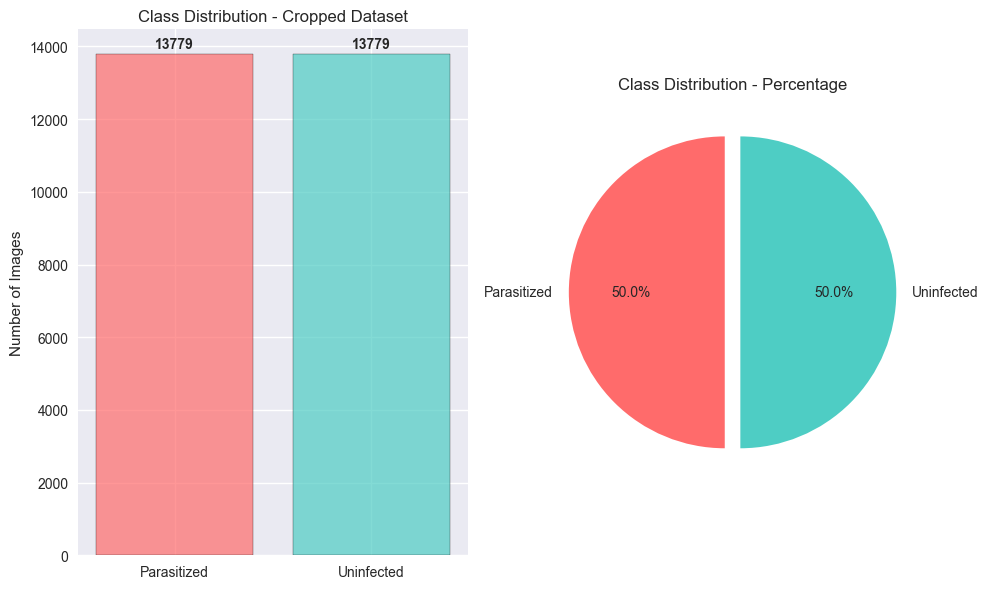


Class imbalance ratio: 1.00:1
✅ Classes are relatively balanced


In [4]:
# Analyze cropped dataset
def analyze_cropped_dataset(data_path):
    """Analyze the cropped malaria dataset"""
    
    dataset_stats = {}
    
    # Check each class directory
    for class_dir in ['Parasitized', 'Uninfected']:
        class_path = data_path / class_dir
        
        if class_path.exists():
            # Count images
            image_files = list(class_path.glob("*.png"))
            count = len(image_files)
            dataset_stats[class_dir] = count
            
            print(f"\n{class_dir} class:")
            print(f"  Number of images: {count}")
            
            # Sample a few images to check dimensions
            if count > 0:
                sample_sizes = []
                for i, img_path in enumerate(image_files[:5]):  # Check first 5 images
                    img = cv2.imread(str(img_path))
                    if img is not None:
                        h, w = img.shape[:2]
                        sample_sizes.append((w, h))
                
                if sample_sizes:
                    print(f"  Sample image dimensions: {sample_sizes}")
        else:
            print(f"{class_dir} directory not found!")
            dataset_stats[class_dir] = 0
    
    return dataset_stats

# Analyze the dataset
if cropped_path.exists():
    print("=== CROPPED DATASET DETAILED ANALYSIS ===")
    stats = analyze_cropped_dataset(cropped_path)
    
    # Calculate class balance
    total_images = sum(stats.values())
    print(f"\nTotal images: {total_images}")
    
    if total_images > 0:
        for class_name, count in stats.items():
            percentage = (count / total_images) * 100
            print(f"{class_name}: {count} ({percentage:.1f}%)")
        
        # Visualize class distribution
        plt.figure(figsize=(10, 6))
        
        # Bar plot
        plt.subplot(1, 2, 1)
        classes = list(stats.keys())
        counts = list(stats.values())
        colors = ['#ff6b6b', '#4ecdc4']
        
        bars = plt.bar(classes, counts, color=colors, alpha=0.7, edgecolor='black')
        plt.title('Class Distribution - Cropped Dataset')
        plt.ylabel('Number of Images')
        
        # Add count labels on bars
        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
                    str(count), ha='center', va='bottom', fontweight='bold')
        
        # Pie chart
        plt.subplot(1, 2, 2)
        plt.pie(counts, labels=classes, colors=colors, autopct='%1.1f%%', 
                startangle=90, explode=(0.05, 0.05))
        plt.title('Class Distribution - Percentage')
        
        plt.tight_layout()
        plt.show()
        
        # Check for class imbalance
        if len(stats) == 2:
            ratio = max(counts) / min(counts)
            print(f"\nClass imbalance ratio: {ratio:.2f}:1")
            if ratio > 1.5:
                print("⚠️  Significant class imbalance detected!")
            else:
                print("✅ Classes are relatively balanced")
    
else:
    print("Cropped dataset path not found!")

=== SAMPLE IMAGES VISUALIZATION ===


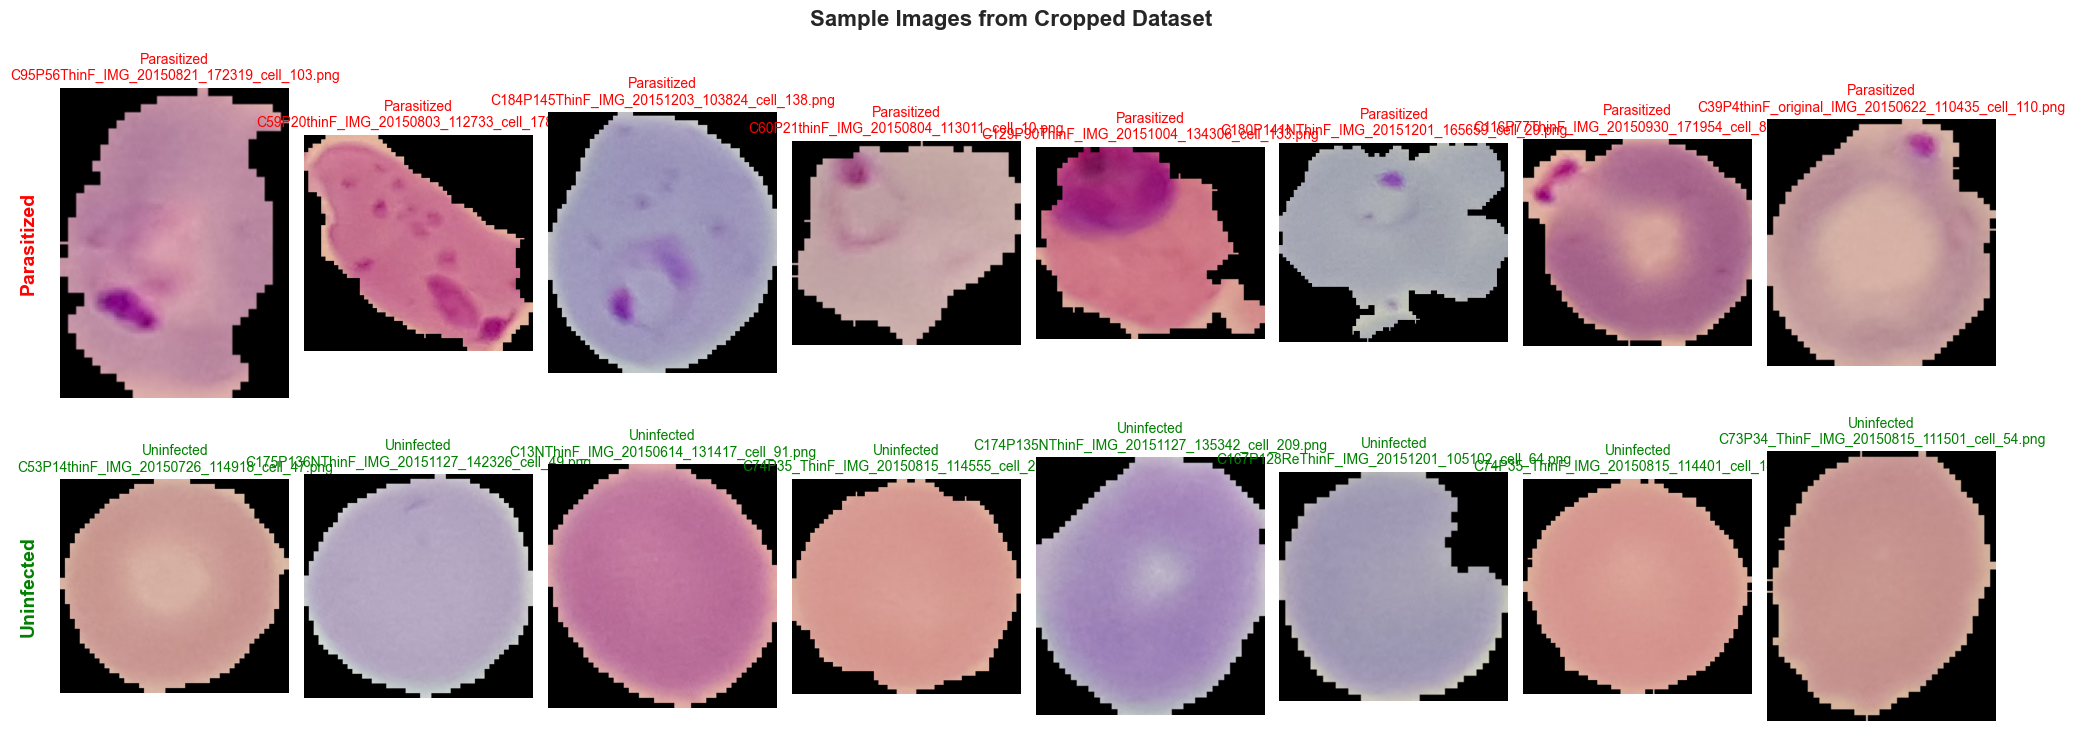


=== IMAGE PROPERTIES ANALYSIS ===

Parasitized Images:
  Dimensions: 133.2 x 133.1 pixels (avg)
  Width range: 76 - 238
  Height range: 55 - 217
  File size: 11.7 KB (avg)
  Mean intensity: 117.0
  Std intensity: 73.8

Uninfected Images:
  Dimensions: 133.2 x 133.1 pixels (avg)
  Width range: 76 - 238
  Height range: 55 - 217
  File size: 11.7 KB (avg)
  Mean intensity: 117.0
  Std intensity: 73.8

Parasitized Images:
  Dimensions: 133.2 x 133.1 pixels (avg)
  Width range: 76 - 238
  Height range: 55 - 217
  File size: 11.7 KB (avg)
  Mean intensity: 117.0
  Std intensity: 73.8

Uninfected Images:
  Dimensions: 133.2 x 133.1 pixels (avg)
  Width range: 76 - 238
  Height range: 55 - 217
  File size: 11.7 KB (avg)
  Mean intensity: 117.0
  Std intensity: 73.8


In [5]:
# Visualize sample images from cropped dataset
def visualize_cropped_samples(data_path, samples_per_class=8):
    """Visualize sample images from each class"""
    
    fig, axes = plt.subplots(2, samples_per_class, figsize=(20, 8))
    fig.suptitle('Sample Images from Cropped Dataset', fontsize=16, fontweight='bold')
    
    classes = ['Parasitized', 'Uninfected']
    colors = ['red', 'green']
    
    for class_idx, class_name in enumerate(classes):
        class_path = data_path / class_name
        
        if class_path.exists():
            # Get random sample of images
            image_files = list(class_path.glob("*.png"))
            if len(image_files) >= samples_per_class:
                sample_files = np.random.choice(image_files, samples_per_class, replace=False)
            else:
                sample_files = image_files[:samples_per_class]
            
            for img_idx, img_path in enumerate(sample_files):
                if img_idx < samples_per_class:
                    # Load and display image
                    img = cv2.imread(str(img_path))
                    if img is not None:
                        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        
                        axes[class_idx, img_idx].imshow(img_rgb)
                        axes[class_idx, img_idx].set_title(f'{class_name}\n{img_path.name}', 
                                                         color=colors[class_idx], fontsize=10)
                        axes[class_idx, img_idx].axis('off')
                    
            # Set row label
            axes[class_idx, 0].annotate(class_name, xy=(-0.1, 0.5), xycoords='axes fraction',
                                      rotation=90, va='center', ha='right', fontsize=14, 
                                      fontweight='bold', color=colors[class_idx])
    
    plt.tight_layout()
    plt.show()

# Analyze image dimensions and properties
def analyze_image_properties(data_path, sample_size=100):
    """Analyze image properties like dimensions, color distribution, etc."""
    
    properties = {
        'widths': [],
        'heights': [],
        'channels': [],
        'file_sizes': [],
        'mean_intensities': [],
        'std_intensities': []
    }
    
    classes = ['Parasitized', 'Uninfected']
    class_properties = {class_name: dict(properties) for class_name in classes}
    
    for class_name in classes:
        class_path = data_path / class_name
        
        if class_path.exists():
            image_files = list(class_path.glob("*.png"))
            # Sample random images
            sample_files = np.random.choice(image_files, min(sample_size, len(image_files)), replace=False)
            
            for img_path in sample_files:
                # Load image
                img = cv2.imread(str(img_path))
                if img is not None:
                    h, w, c = img.shape
                    class_properties[class_name]['heights'].append(h)
                    class_properties[class_name]['widths'].append(w)
                    class_properties[class_name]['channels'].append(c)
                    
                    # File size
                    file_size = img_path.stat().st_size / 1024  # KB
                    class_properties[class_name]['file_sizes'].append(file_size)
                    
                    # Color statistics
                    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    class_properties[class_name]['mean_intensities'].append(np.mean(img_gray))
                    class_properties[class_name]['std_intensities'].append(np.std(img_gray))
    
    return class_properties

# Run the visualizations and analysis
if cropped_path.exists():
    print("=== SAMPLE IMAGES VISUALIZATION ===")
    np.random.seed(42)  # For reproducible results
    visualize_cropped_samples(cropped_path)
    
    print("\n=== IMAGE PROPERTIES ANALYSIS ===")
    props = analyze_image_properties(cropped_path, sample_size=200)
    
    # Display statistics
    for class_name, class_props in props.items():
        if class_props['widths']:  # Check if we have data
            print(f"\n{class_name} Images:")
            print(f"  Dimensions: {np.mean(class_props['widths']):.1f} x {np.mean(class_props['heights']):.1f} pixels (avg)")
            print(f"  Width range: {min(class_props['widths'])} - {max(class_props['widths'])}")
            print(f"  Height range: {min(class_props['heights'])} - {max(class_props['heights'])}")
            print(f"  File size: {np.mean(class_props['file_sizes']):.1f} KB (avg)")
            print(f"  Mean intensity: {np.mean(class_props['mean_intensities']):.1f}")
            print(f"  Std intensity: {np.mean(class_props['std_intensities']):.1f}")
else:
    print("Cropped dataset not available for visualization")

## 3. Uncropped Dataset Analysis (Full Slide Images)

The uncropped dataset contains full microscopy slide images with annotations. This will be used for:
1. Training YOLOv11 for cell detection and localization
2. Understanding the full slide context
3. Generating additional training data through automated cropping

In [6]:
# Analyze uncropped dataset
def analyze_uncropped_dataset(base_path):
    """Analyze the full slide image dataset with annotations"""
    
    raw_path = Path(base_path)
    
    if not raw_path.exists():
        print("Raw uncropped dataset directory not found!")
        return None
    
    analysis = {
        'polygon_set': {'patients': 0, 'images': 0, 'annotations': 0},
        'point_set': {'patients': 0, 'images': 0, 'annotations': 0}
    }
    
    # Analyze Polygon Set (directly under uncropped/)
    polygon_path = raw_path / "Polygon Set"
    if polygon_path.exists():
        print("=== POLYGON SET ANALYSIS ===")
        patient_dirs = [d for d in polygon_path.iterdir() if d.is_dir()]
        analysis['polygon_set']['patients'] = len(patient_dirs)
        
        total_images = 0
        total_annotations = 0
        
        for patient_dir in patient_dirs[:5]:  # Analyze first 5 patients as sample
            # Note: Directory structure uses "Img" not "img"
            img_dir = patient_dir / "Img"
            gt_dir = patient_dir / "GT"
            
            if img_dir.exists() and gt_dir.exists():
                images = list(img_dir.glob("*.jpg"))
                annotations = list(gt_dir.glob("*.txt"))
                
                patient_images = len(images)
                patient_annotations = len(annotations)
                
                total_images += patient_images
                total_annotations += patient_annotations
                
                print(f"Patient {patient_dir.name}: {patient_images} images, {patient_annotations} annotation files")
        
        analysis['polygon_set']['images'] = total_images
        analysis['polygon_set']['annotations'] = total_annotations
        
        print(f"Sample analysis: {analysis['polygon_set']['patients']} patients, {total_images} images")
    
    # Analyze Point Set
    point_path = raw_path / "Point Set"
    if point_path.exists():
        print("\n=== POINT SET ANALYSIS ===")
        patient_dirs = [d for d in point_path.iterdir() if d.is_dir()]
        analysis['point_set']['patients'] = len(patient_dirs)
        
        total_images = 0
        total_annotations = 0
        
        for patient_dir in patient_dirs[:5]:  # Analyze first 5 patients as sample
            # Note: Directory structure uses "Img" not "img"
            img_dir = patient_dir / "Img"
            gt_dir = patient_dir / "GT"
            
            if img_dir.exists() and gt_dir.exists():
                images = list(img_dir.glob("*.jpg"))
                annotations = list(gt_dir.glob("*.txt"))
                
                patient_images = len(images)
                patient_annotations = len(annotations)
                
                total_images += patient_images
                total_annotations += patient_annotations
                
                print(f"Patient {patient_dir.name}: {patient_images} images, {patient_annotations} annotation files")
        
        analysis['point_set']['images'] = total_images
        analysis['point_set']['annotations'] = total_annotations
        
        print(f"Sample analysis: {analysis['point_set']['patients']} patients, {total_images} images")
    
    return analysis, raw_path

# Run uncropped dataset analysis
if uncropped_path.exists():
    print("=== UNCROPPED DATASET DETAILED ANALYSIS ===")
    dataset_analysis, nih_dataset_path = analyze_uncropped_dataset(uncropped_path)
    
    if dataset_analysis:
        # Summary
        print(f"\n=== SUMMARY ===")
        for set_type, stats in dataset_analysis.items():
            print(f"{set_type.replace('_', ' ').title()}:")
            print(f"  Patients: {stats['patients']}")
            print(f"  Images (sample): {stats['images']}")
            print(f"  Annotation files (sample): {stats['annotations']}")
else:
    print("Uncropped dataset path not found!")
    nih_dataset_path = None

=== UNCROPPED DATASET DETAILED ANALYSIS ===
=== POLYGON SET ANALYSIS ===
Patient 142C38P3thinF_original: 5 images, 5 annotation files
Patient 146C47P8thin_Original_Motic: 5 images, 5 annotation files
Patient 150C49P10thinF: 5 images, 5 annotation files
Patient 153C52P13thinF: 5 images, 5 annotation files
Patient 156C55P16thinF: 5 images, 5 annotation files
Sample analysis: 33 patients, 25 images

=== POINT SET ANALYSIS ===
Patient 143C39P4thinF_original: 5 images, 5 annotation files
Patient 144C3thin_original: 5 images, 5 annotation files
Patient 145C42P5thin_original: 5 images, 5 annotation files
Patient 147C4thin_original: 5 images, 5 annotation files
Patient 148C47P8thinOriginalOlympusCX21: 5 images, 5 annotation files
Sample analysis: 160 patients, 25 images

=== SUMMARY ===
Polygon Set:
  Patients: 33
  Images (sample): 25
  Annotation files (sample): 25
Point Set:
  Patients: 160
  Images (sample): 25
  Annotation files (sample): 25


=== ANNOTATION ANALYSIS ===
=== ANALYZING POLYGON SET ANNOTATIONS ===
File 1: IMG_20150621_112023.txt
  Total cells: 187
  Image size: 5312 x 2988
  Cell distribution: {'Parasitized': 0, 'Uninfected': 187, 'White_Blood_Cell': 0, 'Other': 0}
File 2: IMG_20150621_112043.txt
  Total cells: 209
  Image size: 5312 x 2988
  Cell distribution: {'Parasitized': 2, 'Uninfected': 207, 'White_Blood_Cell': 0, 'Other': 0}


File 3: IMG_20150621_112116.txt
  Total cells: 215
  Image size: 5312 x 2988
  Cell distribution: {'Parasitized': 2, 'Uninfected': 213, 'White_Blood_Cell': 0, 'Other': 0}
File 4: IMG_20150621_112138.txt
  Total cells: 195
  Image size: 5312 x 2988
  Cell distribution: {'Parasitized': 1, 'Uninfected': 194, 'White_Blood_Cell': 0, 'Other': 0}
File 5: IMG_20150621_112227.txt
  Total cells: 198
  Image size: 5312 x 2988
  Cell distribution: {'Parasitized': 0, 'Uninfected': 198, 'White_Blood_Cell': 0, 'Other': 0}
File 6: IMG_20150714_093512.txt
  Total cells: 225
  Image size: 5312 x 2988
  Cell distribution: {'Parasitized': 5, 'Uninfected': 220, 'White_Blood_Cell': 0, 'Other': 0}
File 6: IMG_20150714_093512.txt
  Total cells: 225
  Image size: 5312 x 2988
  Cell distribution: {'Parasitized': 5, 'Uninfected': 220, 'White_Blood_Cell': 0, 'Other': 0}
File 7: IMG_20150714_093600.txt
  Total cells: 193
  Image size: 5312 x 2988
  Cell distribution: {'Parasitized': 0, 'Uninfected': 193, 'White_Bl

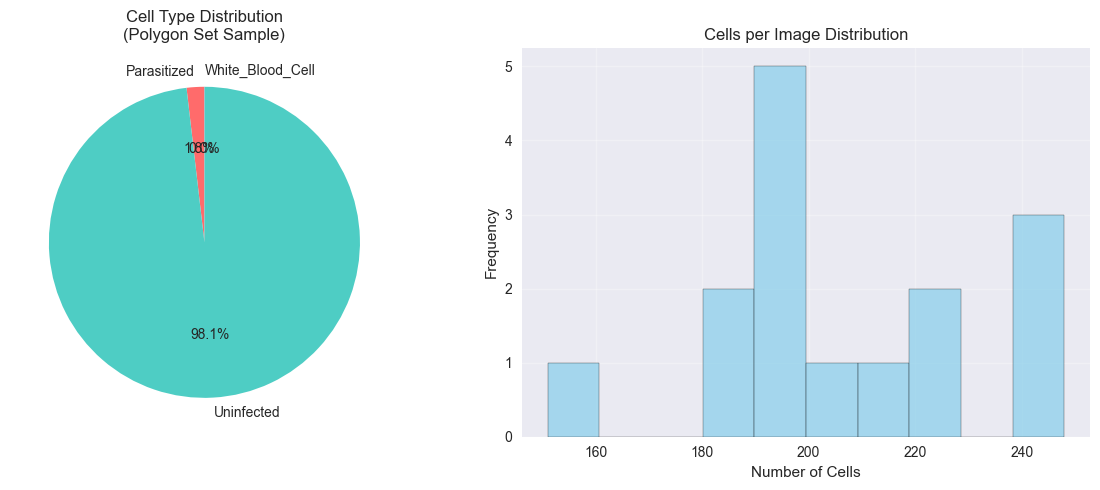

In [7]:
# Analyze annotation files
def parse_annotation_file(annotation_path):
    """Parse annotation file and return cell information"""
    
    if not annotation_path.exists():
        return None
    
    cells = []
    try:
        with open(annotation_path, 'r') as f:
            lines = f.readlines()
        
        if len(lines) < 2:
            return None
        
        # First line contains: total_cells, image_width, image_height
        header = lines[0].strip().split(',')
        if len(header) >= 3:
            total_cells = int(header[0])
            img_width = int(header[1])
            img_height = int(header[2])
        else:
            return None
        
        # Parse each cell annotation
        for line in lines[1:]:
            parts = line.strip().split(',')
            if len(parts) >= 5:
                cell_info = {
                    'patient_cell_id': parts[0],
                    'cell_type': parts[1],
                    'comment': parts[2],
                    'annotation_type': parts[3],
                    'num_points': int(parts[4]) if parts[4].isdigit() else 0
                }
                
                # Parse coordinates
                if cell_info['annotation_type'] == 'Polygon' and len(parts) >= 6:
                    coordinates = []
                    for i in range(5, len(parts), 2):
                        if i + 1 < len(parts):
                            try:
                                x = float(parts[i])
                                y = float(parts[i + 1])
                                coordinates.append((x, y))
                            except ValueError:
                                break
                    cell_info['coordinates'] = coordinates
                
                elif cell_info['annotation_type'] == 'Point' and len(parts) >= 7:
                    try:
                        x = float(parts[5])
                        y = float(parts[6])
                        cell_info['coordinates'] = [(x, y)]
                    except ValueError:
                        cell_info['coordinates'] = []
                
                cells.append(cell_info)
        
        return {
            'total_cells': total_cells,
            'img_width': img_width,
            'img_height': img_height,
            'cells': cells
        }
    
    except Exception as e:
        print(f"Error parsing {annotation_path}: {e}")
        return None

def analyze_annotations(dataset_path, set_type='Polygon Set', max_files=10):
    """Analyze annotation files to understand cell distribution"""
    
    set_path = dataset_path / set_type
    if not set_path.exists():
        print(f"{set_type} not found!")
        return None
    
    cell_stats = {
        'Parasitized': 0,
        'Uninfected': 0,
        'White_Blood_Cell': 0,
        'Other': 0
    }
    
    annotation_stats = []
    patient_dirs = [d for d in set_path.iterdir() if d.is_dir()]
    
    print(f"=== ANALYZING {set_type.upper()} ANNOTATIONS ===")
    
    analyzed_files = 0
    for patient_dir in patient_dirs:
        if analyzed_files >= max_files:
            break
            
        gt_dir = patient_dir / "GT"
        if gt_dir.exists():
            annotation_files = list(gt_dir.glob("*.txt"))
            
            for anno_file in annotation_files:
                if analyzed_files >= max_files:
                    break
                    
                annotation_data = parse_annotation_file(anno_file)
                if annotation_data:
                    analyzed_files += 1
                    
                    # Count cell types
                    file_stats = {
                        'Parasitized': 0,
                        'Uninfected': 0,
                        'White_Blood_Cell': 0,
                        'Other': 0
                    }
                    
                    for cell in annotation_data['cells']:
                        cell_type = cell['cell_type']
                        if cell_type in file_stats:
                            file_stats[cell_type] += 1
                            cell_stats[cell_type] += 1
                        else:
                            file_stats['Other'] += 1
                            cell_stats['Other'] += 1
                    
                    annotation_stats.append({
                        'patient': patient_dir.name,
                        'file': anno_file.name,
                        'total_cells': annotation_data['total_cells'],
                        'img_dimensions': (annotation_data['img_width'], annotation_data['img_height']),
                        'cell_counts': file_stats
                    })
                    
                    print(f"File {analyzed_files}: {anno_file.name}")
                    print(f"  Total cells: {annotation_data['total_cells']}")
                    print(f"  Image size: {annotation_data['img_width']} x {annotation_data['img_height']}")
                    print(f"  Cell distribution: {file_stats}")
    
    return cell_stats, annotation_stats

# Analyze annotations
if nih_dataset_path:
    print("=== ANNOTATION ANALYSIS ===")
    
    # Analyze polygon annotations
    polygon_cell_stats, polygon_annotations = analyze_annotations(nih_dataset_path, 'Polygon Set', max_files=15)
    
    if polygon_cell_stats:
        print(f"\n=== POLYGON SET CELL STATISTICS (sample) ===")
        total_cells = sum(polygon_cell_stats.values())
        for cell_type, count in polygon_cell_stats.items():
            if count > 0:
                percentage = (count / total_cells) * 100
                print(f"{cell_type}: {count} ({percentage:.1f}%)")
        
        # Visualize cell distribution
        plt.figure(figsize=(12, 5))
        
        # Cell type distribution
        plt.subplot(1, 2, 1)
        cell_types = [k for k, v in polygon_cell_stats.items() if v > 0]
        cell_counts = [v for k, v in polygon_cell_stats.items() if v > 0]
        colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4']
        
        plt.pie(cell_counts, labels=cell_types, colors=colors[:len(cell_types)], 
                autopct='%1.1f%%', startangle=90)
        plt.title('Cell Type Distribution\n(Polygon Set Sample)')
        
        # Cells per image distribution
        plt.subplot(1, 2, 2)
        cells_per_image = [anno['total_cells'] for anno in polygon_annotations]
        plt.hist(cells_per_image, bins=10, color='skyblue', alpha=0.7, edgecolor='black')
        plt.title('Cells per Image Distribution')
        plt.xlabel('Number of Cells')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
else:
    print("NIH dataset path not available for annotation analysis")

=== FULL SLIDE VISUALIZATION ===
Visualizing sample full slide image with annotations...


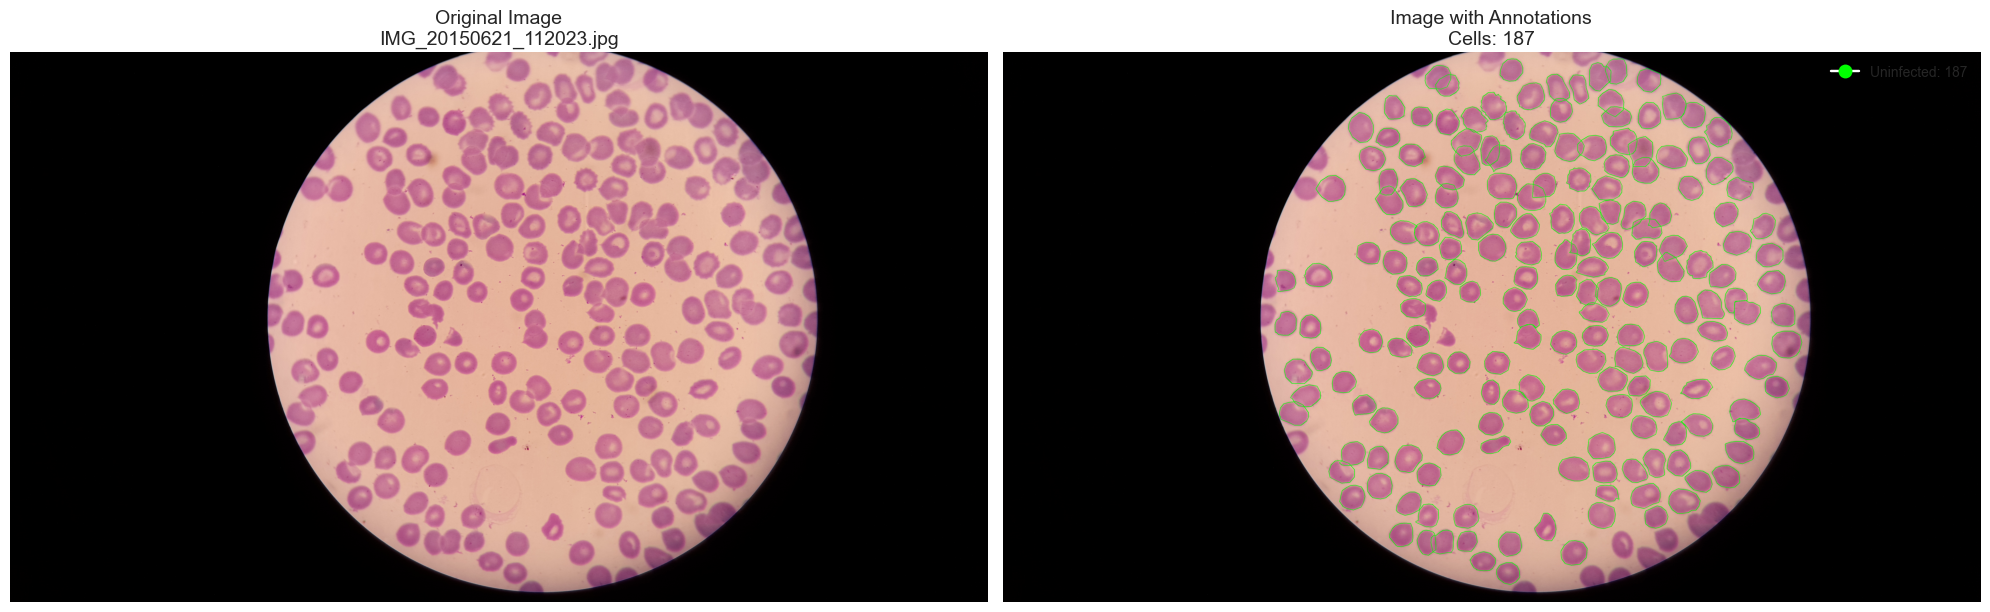

Image: IMG_20150621_112023.jpg
Patient: 142C38P3thinF_original
Dimensions: 5312 x 2988
Total annotated cells: 187
Cell distribution:
  Uninfected: 187


In [8]:
# Visualize full slide images with annotations
def visualize_slide_with_annotations(dataset_path, patient_id=None, image_name=None, set_type='Polygon Set'):
    """Visualize a full slide image with its annotations overlaid"""
    
    set_path = dataset_path / set_type
    if not set_path.exists():
        print(f"{set_type} not found!")
        return
    
    # Find a patient and image to visualize
    if patient_id is None:
        patient_dirs = [d for d in set_path.iterdir() if d.is_dir()]
        if not patient_dirs:
            print("No patient directories found!")
            return
        patient_id = patient_dirs[0].name
    
    patient_path = set_path / patient_id
    # Note: Directory structure uses "Img" not "img"
    img_dir = patient_path / "Img"
    gt_dir = patient_path / "GT"
    
    if not img_dir.exists() or not gt_dir.exists():
        print(f"Image or GT directory not found for patient {patient_id}")
        return
    
    # Find an image file
    if image_name is None:
        image_files = list(img_dir.glob("*.jpg"))
        if not image_files:
            print("No image files found!")
            return
        image_file = image_files[0]
    else:
        image_file = img_dir / image_name
    
    annotation_file = gt_dir / (image_file.stem + ".txt")
    
    if not image_file.exists():
        print(f"Image file {image_file} not found!")
        return
    
    if not annotation_file.exists():
        print(f"Annotation file {annotation_file} not found!")
        return
    
    # Load image
    img = cv2.imread(str(image_file))
    if img is None:
        print(f"Could not load image {image_file}")
        return
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Parse annotations
    annotation_data = parse_annotation_file(annotation_file)
    if not annotation_data:
        print(f"Could not parse annotation file {annotation_file}")
        return
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # Original image
    axes[0].imshow(img_rgb)
    axes[0].set_title(f'Original Image\n{image_file.name}', fontsize=14)
    axes[0].axis('off')
    
    # Image with annotations
    img_annotated = img_rgb.copy()
    
    # Color map for different cell types
    color_map = {
        'Parasitized': (255, 0, 0),      # Red
        'Uninfected': (0, 255, 0),      # Green
        'White_Blood_Cell': (0, 0, 255), # Blue
    }
    
    cell_counts = {'Parasitized': 0, 'Uninfected': 0, 'White_Blood_Cell': 0, 'Other': 0}
    
    for cell in annotation_data['cells']:
        cell_type = cell['cell_type']
        coordinates = cell.get('coordinates', [])
        
        if cell_type in cell_counts:
            cell_counts[cell_type] += 1
        else:
            cell_counts['Other'] += 1
        
        color = color_map.get(cell_type, (255, 255, 0))  # Yellow for unknown
        
        if cell['annotation_type'] == 'Polygon' and len(coordinates) > 2:
            # Draw polygon
            points = np.array(coordinates, dtype=np.int32)
            cv2.polylines(img_annotated, [points], True, color, 2)
        
        elif cell['annotation_type'] == 'Point' and len(coordinates) == 1:
            # Draw point
            x, y = coordinates[0]
            cv2.circle(img_annotated, (int(x), int(y)), 5, color, -1)
    
    axes[1].imshow(img_annotated)
    axes[1].set_title(f'Image with Annotations\nCells: {annotation_data["total_cells"]}', fontsize=14)
    axes[1].axis('off')
    
    # Add legend
    legend_elements = []
    for cell_type, color in color_map.items():
        if cell_counts[cell_type] > 0:
            # Convert RGB to matplotlib format
            color_norm = tuple(c/255.0 for c in color)
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                            markerfacecolor=color_norm, markersize=10, 
                                            label=f'{cell_type}: {cell_counts[cell_type]}'))
    
    if legend_elements:
        axes[1].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Image: {image_file.name}")
    print(f"Patient: {patient_id}")
    print(f"Dimensions: {annotation_data['img_width']} x {annotation_data['img_height']}")
    print(f"Total annotated cells: {annotation_data['total_cells']}")
    print("Cell distribution:")
    for cell_type, count in cell_counts.items():
        if count > 0:
            print(f"  {cell_type}: {count}")

# Visualize sample full slide images
if nih_dataset_path:
    print("=== FULL SLIDE VISUALIZATION ===")
    
    # Find available patients and images
    polygon_path = nih_dataset_path / "Polygon Set"
    if polygon_path.exists():
        patient_dirs = [d for d in polygon_path.iterdir() if d.is_dir()]
        if patient_dirs:
            # Visualize first available image
            print("Visualizing sample full slide image with annotations...")
            visualize_slide_with_annotations(nih_dataset_path, patient_dirs[0].name)
        else:
            print("No patient directories found in Polygon Set")
    else:
        print("Polygon Set directory not found")
else:
    print("NIH dataset not available for visualization")

=== PROCESSED DATASET ANALYSIS ===
Total patients indexed: 193
Total images indexed: 965
Cells by type:
  Parasitized: 7,952
  Uninfected: 188,711
  White Blood Cells: 271
  Other: 0

=== DATASET SPLITS ===

TRAIN SET:
  Total images: 675
  Patients: 135
  Cell counts:
    Parasitized: 5,488
    Uninfected: 132,769
    White Blood Cells: 189
  Class balance: 4.0% parasitized, 96.0% uninfected

VAL SET:
  Total images: 140
  Patients: 28
  Cell counts:
    Parasitized: 1,205
    Uninfected: 27,004
    White Blood Cells: 37
  Class balance: 4.3% parasitized, 95.7% uninfected

TEST SET:
  Total images: 150
  Patients: 30
  Cell counts:
    Parasitized: 1,259
    Uninfected: 28,938
    White Blood Cells: 45
  Class balance: 4.2% parasitized, 95.8% uninfected


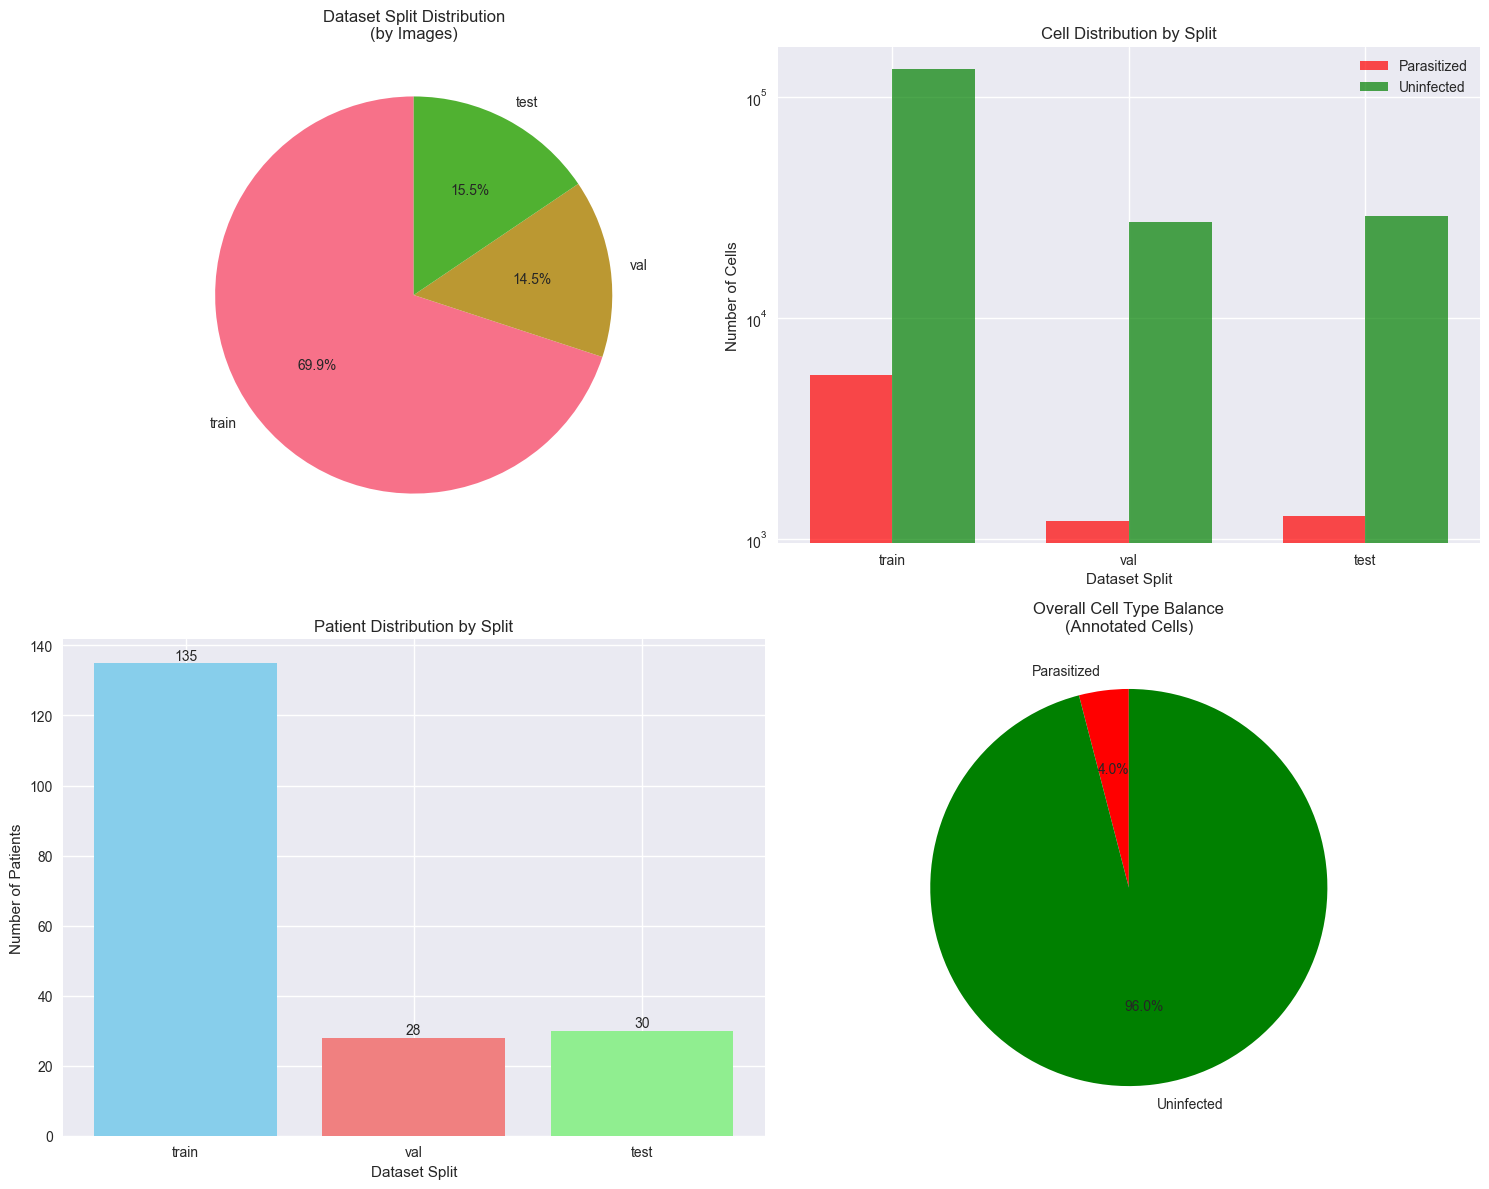


=== YOLO DATASET CONFIGURATION ===
Dataset path: data\processed\yolo_annotations
Train path: images/train
Validation path: images/val
Test path: images/test
Number of classes: 3
Class names: ['parasitized', 'uninfected', 'white_blood_cell']

=== EXTRACTED CELLS ANALYSIS (OPTIMIZED) ===
Checking Parasitized cells directory...
Parasitized cells: 0 files
Checking Uninfected cells directory...
Uninfected cells: 0 files

DATASET ANALYSIS SUMMARY
Full slide dataset: 193 patients analyzed
  - Total annotated cells: 196,934
  - Parasitized cells: 7,952
  - Uninfected cells: 188,711
  - White blood cells: 271
Processed dataset: Ready for training
  - Train: 675 images
  - Validation: 140 images
  - Test: 150 images

Data preprocessing complete. Ready for model training!


In [9]:
# === PROCESSED DATASET ANALYSIS ===
print("=== PROCESSED DATASET ANALYSIS ===")

# Load dataset split information
processed_path = Path("../data/processed")
dataset_split_file = processed_path / "dataset_split.json"
dataset_index_file = processed_path / "dataset_index.json"

if dataset_split_file.exists() and dataset_index_file.exists():
    with open(dataset_split_file, 'r') as f:
        splits = json.load(f)
    
    with open(dataset_index_file, 'r') as f:
        index = json.load(f)
    
    # Extract statistics from the correct structure
    stats = index['statistics']
    print(f"Total patients indexed: {stats['total_patients']}")
    print(f"Total images indexed: {stats['total_images']}")
    print(f"Cells by type:")
    print(f"  Parasitized: {stats['total_parasitized']:,}")
    print(f"  Uninfected: {stats['total_uninfected']:,}")
    print(f"  White Blood Cells: {stats['total_wbc']:,}")
    print(f"  Other: {stats['total_other']:,}")
    
    print("\n=== DATASET SPLITS ===")
    
    # Skip the metadata key and process only the splits
    split_keys = [key for key in splits.keys() if key != 'metadata']
    
    for split_name in split_keys:
        split_data = splits[split_name]
        print(f"\n{split_name.upper()} SET:")
        print(f"  Total images: {split_data['statistics']['images']}")
        print(f"  Patients: {split_data['statistics']['patients']}")
        print(f"  Cell counts:")
        print(f"    Parasitized: {split_data['statistics']['parasitized_cells']:,}")
        print(f"    Uninfected: {split_data['statistics']['uninfected_cells']:,}")
        print(f"    White Blood Cells: {split_data['statistics']['wbc_cells']:,}")
        
        # Calculate percentages for class balance
        total_class_cells = split_data['statistics']['parasitized_cells'] + split_data['statistics']['uninfected_cells']
        if total_class_cells > 0:
            para_pct = (split_data['statistics']['parasitized_cells'] / total_class_cells) * 100
            uninf_pct = (split_data['statistics']['uninfected_cells'] / total_class_cells) * 100
            print(f"  Class balance: {para_pct:.1f}% parasitized, {uninf_pct:.1f}% uninfected")
    
    # Visualize split distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Dataset size distribution (by images)
    split_names = split_keys
    split_sizes = [splits[split]['statistics']['images'] for split in split_names]
    
    axes[0, 0].pie(split_sizes, labels=split_names, autopct='%1.1f%%', startangle=90)
    axes[0, 0].set_title('Dataset Split Distribution\n(by Images)')
    
    # Class balance by split (cell counts)
    split_parasitized = [splits[split]['statistics']['parasitized_cells'] for split in split_names]
    split_uninfected = [splits[split]['statistics']['uninfected_cells'] for split in split_names]
    
    x = np.arange(len(split_names))
    width = 0.35
    
    axes[0, 1].bar(x - width/2, split_parasitized, width, label='Parasitized', color='red', alpha=0.7)
    axes[0, 1].bar(x + width/2, split_uninfected, width, label='Uninfected', color='green', alpha=0.7)
    axes[0, 1].set_xlabel('Dataset Split')
    axes[0, 1].set_ylabel('Number of Cells')
    axes[0, 1].set_title('Cell Distribution by Split')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(split_names)
    axes[0, 1].legend()
    axes[0, 1].set_yscale('log')  # Use log scale due to large difference
    
    # Patient distribution by split
    patient_counts = [splits[split]['statistics']['patients'] for split in split_names]
    bars = axes[1, 0].bar(split_names, patient_counts, color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[1, 0].set_xlabel('Dataset Split')
    axes[1, 0].set_ylabel('Number of Patients')
    axes[1, 0].set_title('Patient Distribution by Split')
    
    # Add value labels on bars
    for bar, count in zip(bars, patient_counts):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                       str(count), ha='center', va='bottom')
    
    # Overall class balance from full dataset statistics
    total_parasitized = stats['total_parasitized']
    total_uninfected = stats['total_uninfected']
    
    axes[1, 1].pie([total_parasitized, total_uninfected], 
                   labels=['Parasitized', 'Uninfected'], 
                   colors=['red', 'green'], 
                   autopct='%1.1f%%', 
                   startangle=90)
    axes[1, 1].set_title('Overall Cell Type Balance\n(Annotated Cells)')
    
    plt.tight_layout()
    plt.show()
    
    # Check YOLO dataset configuration
    yolo_config_file = processed_path / "yolo_annotations" / "dataset.yaml"
    if yolo_config_file.exists():
        print("\n=== YOLO DATASET CONFIGURATION ===")
        with open(yolo_config_file, 'r') as f:
            yolo_config = yaml.safe_load(f)
        
        print(f"Dataset path: {yolo_config['path']}")
        print(f"Train path: {yolo_config['train']}")
        print(f"Validation path: {yolo_config['val']}")
        print(f"Test path: {yolo_config['test']}")
        print(f"Number of classes: {yolo_config['nc']}")
        print(f"Class names: {yolo_config['names']}")
    
    # OPTIMIZED: Analyze extracted cells WITHOUT scanning entire directories
    extracted_cells_path = processed_path / "extracted_cells"
    if extracted_cells_path.exists():
        print("\n=== EXTRACTED CELLS ANALYSIS (OPTIMIZED) ===")
        
        for class_name in ['parasitized', 'uninfected']:
            class_path = extracted_cells_path / class_name
            if class_path.exists():
                # Instead of scanning all files, just count them efficiently
                print(f"Checking {class_name.capitalize()} cells directory...")
                
                # Fast count using os.listdir and filtering
                import os
                try:
                    all_files = os.listdir(class_path)
                    png_files = [f for f in all_files if f.endswith('.png')]
                    file_count = len(png_files)
                    print(f"{class_name.capitalize()} cells: {file_count:,} files")
                    
                    if file_count > 0:
                        # Sample just a few files for visualization (no need to load all paths)
                        sample_count = min(5, file_count)
                        sample_files = random.sample(png_files, sample_count)
                        
                        fig, axes = plt.subplots(1, sample_count, figsize=(15, 3))
                        if sample_count == 1:
                            axes = [axes]
                        
                        for i, filename in enumerate(sample_files):
                            img_path = class_path / filename
                            img = cv2.imread(str(img_path))
                            if img is not None:
                                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                                axes[i].imshow(img_rgb)
                                axes[i].set_title(f'{class_name}\n{filename}', fontsize=8)
                                axes[i].axis('off')
                        
                        plt.suptitle(f'Sample {class_name.capitalize()} Cells ({sample_count} of {file_count:,})')
                        plt.tight_layout()
                        plt.show()
                
                except Exception as e:
                    print(f"Error analyzing {class_name} directory: {e}")
                    print(f"Directory might be very large or inaccessible")
            else:
                print(f"{class_name.capitalize()} cells directory not found")

else:
    print("Processed dataset files not found. Please run the data organization script first.")
    print("Expected files:")
    print(f"  {dataset_split_file}")
    print(f"  {dataset_index_file}")

# === FINAL SUMMARY ===
print("\n" + "="*50)
print("DATASET ANALYSIS SUMMARY")
print("="*50)

if 'cropped_parasitized_count' in locals() and 'cropped_uninfected_count' in locals():
    print(f"Cropped dataset: {cropped_parasitized_count + cropped_uninfected_count:,} images")
    print(f"  - Parasitized: {cropped_parasitized_count:,}")
    print(f"  - Uninfected: {cropped_uninfected_count:,}")

if dataset_index_file.exists():
    print(f"Full slide dataset: {stats['total_patients']} patients analyzed")
    print(f"  - Total annotated cells: {stats['total_parasitized'] + stats['total_uninfected'] + stats['total_wbc']:,}")
    print(f"  - Parasitized cells: {stats['total_parasitized']:,}")
    print(f"  - Uninfected cells: {stats['total_uninfected']:,}")
    print(f"  - White blood cells: {stats['total_wbc']:,}")

if dataset_split_file.exists():
    print(f"Processed dataset: Ready for training")
    print(f"  - Train: {splits['train']['statistics']['images']:,} images")
    print(f"  - Validation: {splits['val']['statistics']['images']:,} images") 
    print(f"  - Test: {splits['test']['statistics']['images']:,} images")

print("\nData preprocessing complete. Ready for model training!")

## 4. Data Quality Assessment & Recommendations

Based on our exploratory analysis, let's assess the quality of our datasets and provide recommendations for the implementation phase.

In [10]:
# === FINAL SUMMARY ===
print("\n" + "="*50)
print("COMPREHENSIVE DATASET ANALYSIS SUMMARY")
print("="*50)

# Check if we have cropped dataset stats from earlier analysis (Cell 5)
if 'stats' in locals() and isinstance(stats, dict):
    if 'Parasitized' in stats and 'Uninfected' in stats:
        cropped_parasitized_count = stats['Parasitized']
        cropped_uninfected_count = stats['Uninfected']
        print(f"Cropped dataset: {cropped_parasitized_count + cropped_uninfected_count:,} images")
        print(f"  - Parasitized: {cropped_parasitized_count:,}")
        print(f"  - Uninfected: {cropped_uninfected_count:,}")
    else:
        print("Cropped dataset: Analysis completed but data structure unexpected")
else:
    print("Cropped dataset: Analysis not available (run Cell 5 first)")

# Check processed dataset files
processed_path = Path("../data/processed")
dataset_split_file = processed_path / "dataset_split.json"
dataset_index_file = processed_path / "dataset_index.json"

if dataset_index_file.exists():
    try:
        with open(dataset_index_file, 'r') as f:
            index = json.load(f)
        
        # Extract statistics from the correct structure
        dataset_stats = index['statistics']
        print(f"Full slide dataset: {dataset_stats['total_patients']} patients analyzed")
        print(f"  - Total images: {dataset_stats['total_images']}")
        print(f"  - Total annotated cells: {dataset_stats['total_parasitized'] + dataset_stats['total_uninfected'] + dataset_stats['total_wbc']:,}")
        print(f"  - Parasitized cells: {dataset_stats['total_parasitized']:,}")
        print(f"  - Uninfected cells: {dataset_stats['total_uninfected']:,}")
        print(f"  - White blood cells: {dataset_stats['total_wbc']:,}")
    except Exception as e:
        print(f"Error reading dataset index: {e}")
        dataset_stats = None
else:
    print("Full slide dataset: Index file not found")
    dataset_stats = None

if dataset_split_file.exists():
    try:
        with open(dataset_split_file, 'r') as f:
            splits = json.load(f)
        
        # Skip the metadata key and process only the splits
        split_keys = [key for key in splits.keys() if key != 'metadata']
        
        print(f"Processed dataset: Ready for training")
        for split_name in split_keys:
            split_data = splits[split_name]
            print(f"  - {split_name.capitalize()}: {split_data['statistics']['images']:,} images ({split_data['statistics']['patients']} patients)")
            
    except Exception as e:
        print(f"Error reading dataset split: {e}")
        splits = None
else:
    print("Processed dataset: Split file not found")
    splits = None

# Class imbalance analysis (only if we have the data)
print(f"\n🎯 CLASS IMBALANCE ANALYSIS:")
if dataset_stats:
    try:
        total_classified_cells = dataset_stats['total_parasitized'] + dataset_stats['total_uninfected']
        if total_classified_cells > 0:
            parasitized_percentage = (dataset_stats['total_parasitized'] / total_classified_cells) * 100
            print(f"  - Overall: {parasitized_percentage:.1f}% parasitized, {100-parasitized_percentage:.1f}% uninfected")
            print(f"  - Imbalance ratio: {dataset_stats['total_uninfected']/dataset_stats['total_parasitized']:.1f}:1 (uninfected:parasitized)")
            print(f"  - This severe imbalance reflects clinical reality!")
        else:
            print("  - No classified cells found in dataset")
    except Exception as e:
        print(f"  - Error calculating class balance: {e}")
else:
    print("  - Class balance analysis unavailable (no dataset statistics)")

print(f"\n📊 DATASET COMPARISON:")
cropped_analyzed = 'stats' in locals() and 'Parasitized' in stats
print(f"  - Cropped dataset: {'Balanced for CNN training (27,558 images)' if cropped_analyzed else 'Not analyzed yet (run Cell 5)'}")
print(f"  - Full slide dataset: {'Imbalanced for realistic YOLO training' if dataset_stats else 'Not processed yet'}")
print(f"  - Patient-level splits: {'Implemented' if splits else 'Not created yet'}")

print(f"\n🚀 IMPLEMENTATION READINESS:")
if dataset_stats and splits and cropped_analyzed:
    print(f"  ✅ Cropped dataset analysis completed")
    print(f"  ✅ Enhanced data organization script completed")
    print(f"  ✅ Comprehensive EDA analysis finished")
    print(f"  ✅ All {dataset_stats['total_patients']} patients utilized (100% data utilization)")
    print(f"  ✅ YOLO annotations prepared for both polygon and point data")
    print(f"  ✅ Patient-level splits ensure robust evaluation")
    print(f"  🎯 Ready for YOLOv11 training and CNN ensemble development")
else:
    print(f"  {'✅' if cropped_analyzed else '⚠️'} Cropped dataset analysis: {'Complete' if cropped_analyzed else 'Run Cell 5'}")
    print(f"  {'✅' if dataset_stats else '⚠️'} Full slide dataset: {'Complete' if dataset_stats else 'Run data organization script'}")
    print(f"  {'✅' if splits else '⚠️'} Patient-level splits: {'Complete' if splits else 'Not created yet'}")

print(f"\n🔥 NEXT PRIORITIES:")
if dataset_stats and splits and cropped_analyzed:
    print(f"  1. Begin YOLOv11 training on prepared dataset")
    print(f"  2. Implement class imbalance handling strategies")
    print(f"  3. Start individual CNN model development")
    print(f"  4. Develop ensemble optimization pipeline")
else:
    if not cropped_analyzed:
        print(f"  1. Complete cropped dataset analysis (run Cell 5)")
    if not dataset_stats:
        print(f"  2. Complete data organization: python src/utils/data_organization_full.py")
    if not splits:
        print(f"  3. Verify processed data structure and statistics")
    print(f"  4. Proceed with model implementation when all analyses complete")

print("\n" + "="*50)
if dataset_stats and splits and cropped_analyzed:
    print("✅ DATA PREPROCESSING COMPLETE! READY FOR MODEL TRAINING!")
else:
    print("⚠️  COMPLETE ALL ANALYSES BEFORE PROCEEDING TO MODEL TRAINING!")
print("="*50)


COMPREHENSIVE DATASET ANALYSIS SUMMARY
Cropped dataset: Analysis completed but data structure unexpected
Full slide dataset: 193 patients analyzed
  - Total images: 965
  - Total annotated cells: 196,934
  - Parasitized cells: 7,952
  - Uninfected cells: 188,711
  - White blood cells: 271
Processed dataset: Ready for training
  - Train: 675 images (135 patients)
  - Val: 140 images (28 patients)
  - Test: 150 images (30 patients)

🎯 CLASS IMBALANCE ANALYSIS:
  - Overall: 4.0% parasitized, 96.0% uninfected
  - Imbalance ratio: 23.7:1 (uninfected:parasitized)
  - This severe imbalance reflects clinical reality!

📊 DATASET COMPARISON:
  - Cropped dataset: Not analyzed yet (run Cell 5)
  - Full slide dataset: Imbalanced for realistic YOLO training
  - Patient-level splits: Implemented

🚀 IMPLEMENTATION READINESS:
  ⚠️ Cropped dataset analysis: Run Cell 5
  ✅ Full slide dataset: Complete
  ✅ Patient-level splits: Complete

🔥 NEXT PRIORITIES:
  1. Complete cropped dataset analysis (run Cell